# Chapter 11 - Hedging
&copy; 2019 Kenneth Winston

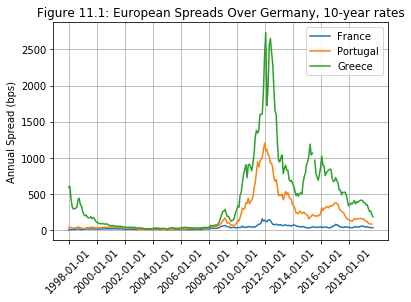

Ending values  2019-12-31
France -0.35
Portugal nan
Greece nan


In [1]:
%matplotlib inline
import pandas as pd
import qrpm_funcs as qf
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import stats
#Get European rates - show spreads

lastday=qf.LastYearEnd()
#Swiss franc, pound sterling, Japanese Yen
seriesnames=['IRLTLT01DEM156N','IRLTLT01FRM156N','IRLTLT01PTM156N','IRLTLT01GRM156N']
shortnames=['France','Portugal','Greece']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate='1998-01-01',enddate=lastday)
nobs=len(cdates)
x=range(nobs)
for i in range(len(shortnames)):
    plt.plot(x,[(y[i+1]-y[0])*100 for y in ratematrix],label=shortnames[i])

plt.ylabel("Annual Spread (bps)")
stride=24
plt.xticks(range(0,nobs,stride),cdates[::stride],rotation=45)
plt.legend()
plt.grid()
plt.title("Figure 11.1: European Spreads Over Germany, 10-year rates")
plt.show();

print("Ending values ",lastday)
for i in range(len(shortnames)):
    print(shortnames[i],ratematrix[-1][i])

In [2]:
import pandas as pd
import ssl

#Get data for text
seriesnames=['DEXUSEU','DGS1']
cdates,ratematrix=qf.GetFREDMatrix(seriesnames,startdate=lastday,enddate=lastday)
print("As of:",cdates[0])
usd_per_euro=ratematrix[0][0]
rt1_us=ratematrix[0][1]
print("    Dollars per euro",usd_per_euro)
print("    US 1-year rate",rt1_us)

#Problem with Bundesbank's certificate - drop verification
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

#Read one-year rates from Bundesbank
bundesbank_url = 'https://www.bundesbank.de/statistic-rmi/StatisticDownload?tsId=BBK01.WZ9808'
bundesbank_url += '&its_fileFormat=csv&mode=its&its_csvFormat=en'
df_csv = pd.read_csv(bundesbank_url,skiprows=4)
df_german = df_csv.rename(index=str, columns={df_csv.columns[0]: "Date", df_csv.columns[1]: "Rate"})
rt1_german=df_german.loc[df_german['Date'] == lastday[:7]]["Rate"].iloc[0]

print("    German 1-year rate",rt1_german)

#Calculate currency forward price per (11.12)
time=1
f_price=usd_per_euro*(1+rt1_us/100.)**time/(1+rt1_german/100.)**time
print("    1yr forward price",f_price)

As of: 2018-12-31
    Dollars per euro 1.1456
    US 1-year rate 2.63
    German 1-year rate -0.7
    1yr forward price 1.1840174018126888


In [3]:
#Calculations for Philippe's investment in XOM
euro_invested=10000.00
usd_invested=euro_invested*usd_per_euro
usd_forward=usd_invested*(1+rt1_us/100)**time
euro_forward=euro_invested*(1+rt1_german/100)**time

print("Philippe's investment in XOM:")
print("    Euros invested",euro_invested)
print("    Dollars invested",usd_invested)
print("    Euros forward",euro_forward)
print("    Dollars forward",usd_forward)
new_xom_value=usd_invested*1.2
print("    20pct up in USD",new_xom_value)
unhedged_xom_gain_usd=new_xom_value-usd_forward
print("    Unhedged USD amount",unhedged_xom_gain_usd)
new_usd_per_euro=5
unhedged_xom_gain_euro=unhedged_xom_gain_usd/new_usd_per_euro
print("    Unhedged amount in euros",unhedged_xom_gain_euro)
print("    Total amount in euros",euro_forward+unhedged_xom_gain_euro)

Philippe's investment in XOM:
    Euros invested 10000.0
    Dollars invested 11456.0
    Euros forward 9930.0
    Dollars forward 11757.2928
    20pct up in USD 13747.199999999999
    Unhedged USD amount 1989.9071999999996
    Unhedged amount in euros 397.9814399999999
    Total amount in euros 10327.98144


In [4]:
#Calculations for Philippe-Ken Wine Company

phil_euro_budget=10000000.
french_bottle_cost=10.
us_bottle_cost=french_bottle_cost*usd_per_euro
ken_usd_budget=phil_euro_budget*usd_per_euro
print("Philippe-Ken Wine Company")
print("    Philippe budget in euros",phil_euro_budget)
print("    Ken budget in dollars",ken_usd_budget)
phil_bottles=phil_euro_budget*usd_per_euro/us_bottle_cost
print("    Philippe original bottles imported",phil_bottles)
ken_bottles=ken_usd_budget/usd_per_euro/french_bottle_cost
print("    Ken original bottles imported",ken_bottles)
print("    Total bottle imports",phil_bottles+ken_bottles)

print("\nDollar strengthens to 1 per euro")
new_upe=1
phil_bottles=phil_euro_budget*new_upe/us_bottle_cost
print("    Philippe strong dollar bottles imported",phil_bottles)
ken_bottles=ken_usd_budget/new_upe/french_bottle_cost
print("    Ken strong dollar bottles imported",ken_bottles)
print("    Total strong dollar bottle imports",phil_bottles+ken_bottles)

print("\nDollar weakens to 1.25 per euro")
new_upe=1.25
phil_bottles=phil_euro_budget*new_upe/us_bottle_cost
print("    Philippe weak dollar bottles imported",phil_bottles)
ken_bottles=ken_usd_budget/new_upe/french_bottle_cost
print("    Ken weak dollar bottles imported",ken_bottles)
print("    Total weak dollar bottle imports",phil_bottles+ken_bottles)

Philippe-Ken Wine Company
    Philippe budget in euros 10000000.0
    Ken budget in dollars 11456000.0
    Philippe original bottles imported 1000000.0
    Ken original bottles imported 1000000.0
    Total bottle imports 2000000.0

Dollar strengthens to 1 per euro
    Philippe strong dollar bottles imported 872905.0279329609
    Ken strong dollar bottles imported 1145600.0
    Total strong dollar bottle imports 2018505.027932961

Dollar weakens to 1.25 per euro
    Philippe weak dollar bottles imported 1091131.2849162011
    Ken weak dollar bottles imported 916480.0
    Total weak dollar bottle imports 2007611.2849162011


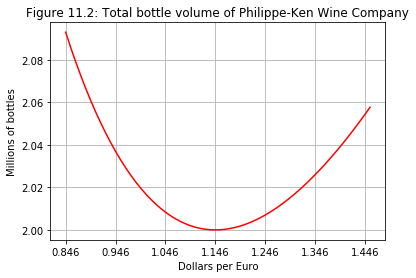

In [5]:
#Show number-of-bottles curve for Siegel's paradox

x=np.arange(usd_per_euro-.3,usd_per_euro+.3+.01,.01)
z=x/usd_per_euro
y=z+1/z

i=np.arange(len(x))
plt.plot(i,y,color='red')
plt.xticks(i[::10],[str(round(float(label), 3)) for label in x[::10]])
plt.xlabel("Dollars per Euro")
plt.ylabel("Millions of bottles")
plt.title("Figure 11.2: Total bottle volume of Philippe-Ken Wine Company")
plt.grid()
plt.show()

In [6]:
#More Siegel's Paradox calculations
low_root=(1-np.sqrt(485))/22
high_root=(1+np.sqrt(485))/22
print("Roots of (11.14) polynomial:",-1,low_root,high_root)

print("Profit less than original between:",usd_per_euro,high_root*usd_per_euro)

#minimum profit location
min_root=(4+np.sqrt(158/3))/11
print("Minimum profit at z,x=",min_root,min_root*usd_per_euro)

#minimum profit amount
min_profit=1000000*(min_root+1)*(11-21*min_root+11*min_root**2)/min_root**2
print("Minimum hedged profit",min_profit)
#Compute unhedge profit at that point
print("Unhedged Profit at minimum hedged profit:",20000000*(1.1*min_root-1))

Roots of (11.14) polynomial: -1 -0.9555779793429654 1.0464870702520563
Profit less than original between: 1.1456 1.1988555876807556
Minimum profit at z,x= 1.0233800320326436 1.1723841646965965
Minimum hedged profit 1988770.9045979201
Unhedged Profit at minimum hedged profit: 2514360.7047181595


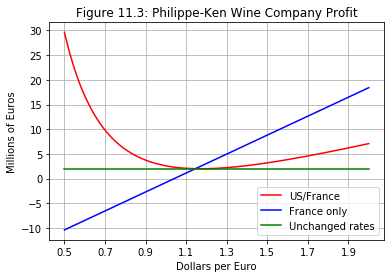

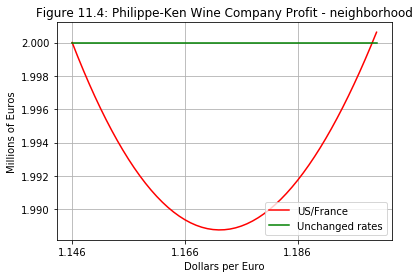

In [7]:
#Show profitability graphs for Siegel's paradox -
#Philippe-Ken Wine Company

#Broad range and narrow range
x=np.arange(.5,2.01,.01)
title_str="Figure 11.3: Philippe-Ken Wine Company Profit"

for graph_no in [1,2]:

    z=x/usd_per_euro
    y_hedged=[(zz+1)*(11-21*zz+11*zz**2)/zz**2 for zz in z]
    y_unhedged=20*(1.1*z-1)
    y_constant=[2]*len(y_hedged)

    i=np.arange(len(x))
    plt.plot(i,y_hedged,color='red',label='US/France')
    if graph_no==1:
        plt.plot(i,y_unhedged,color='blue',label='France only')
    plt.plot(i,y_constant,color='green',label='Unchanged rates')
    plt.xticks(i[::20],[str(round(float(label), 3)) for label in x[::20]])
    plt.xlabel("Dollars per Euro")
    plt.ylabel("Millions of Euros")
    plt.legend(loc='lower right')
    plt.title(title_str)
    plt.grid()
    plt.show()

    #next iteration
    x=np.arange(usd_per_euro,high_root*usd_per_euro+.001,.001)
    title_str="Figure 11.4: Philippe-Ken Wine Company Profit - neighborhood"

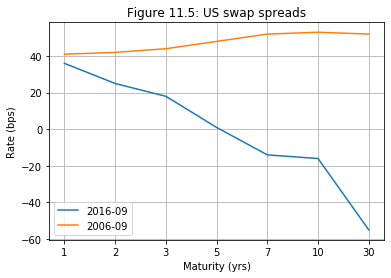

In [8]:
#Swap rates

lastday='2016-09-30'
maturities=[1,2,3,5,7,10,30]

#Swap rates
seriesnames=['MSWP1','MSWP2','MSWP3','MSWP5','MSWP7','MSWP10','MSWP30']
cdates,swapmatrix=qf.GetFREDMatrix(seriesnames,startdate='2000-12-31',enddate=lastday)

#Treasury rates
seriesnames=['GS1','GS2','GS3','GS5','GS7','GS10','GS30']
cdates,tsymatrix=qf.GetFREDMatrix(seriesnames,startdate='2000-12-31',enddate=lastday)

ratematrix=np.multiply(100.,np.subtract(swapmatrix,tsymatrix))

num_points=len(seriesnames)
plt.plot(range(num_points),ratematrix[-1],label=cdates[-1][:7])
plt.plot(range(num_points),ratematrix[-121],label=cdates[-121][:7])

plt.xlabel("Maturity (yrs)")
plt.ylabel("Rate (bps)")
plt.xticks(range(num_points),maturities)
plt.legend()
plt.grid()
plt.title("Figure 11.5: US swap spreads")
plt.show();

In [9]:
# Data behind last point of swap spread curve
print("30-year Treasury rate as of ",lastday[:7],": ",tsymatrix[-1][-1])
print("30-year swap rate as of ",lastday[:7],": ",swapmatrix[-1][-1])
print("30-year swap spread as of ",lastday[:7],": ",ratematrix[-1][-1])

30-year Treasury rate as of  2016-09 :  2.35
30-year swap rate as of  2016-09 :  1.8
30-year swap spread as of  2016-09 :  -55.00000000000001


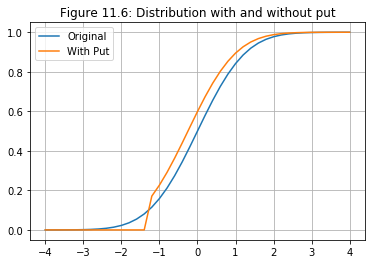

In [10]:
#Shift in distribution function when buying put
import scipy.stats as spst

put_cost=.25
put_strike=-1.

x=np.arange(-4,4.2,.2)
y_norm=spst.norm.cdf(x)
y_put=[]
for i in range(len(x)):
    if x[i]<put_strike-put_cost:
        y_put.append(0.)
    else:
        y_put.append(spst.norm.cdf(x[i]+put_cost))

plt.plot(x,y_norm,label='Original')
plt.plot(x,y_put,label='With Put')
plt.grid()
plt.title("Figure 11.6: Distribution with and without put")
plt.legend()
plt.show()

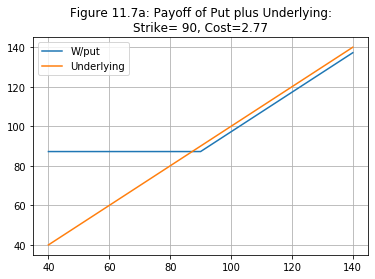

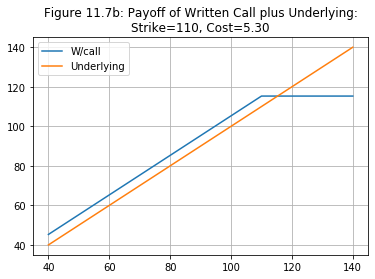

In [11]:
#Show payoff patterns for buying a put and writing a call

x=np.arange(40,145,5)
put_strike=90
put_cost=2.77
put_plus_under=[max(put_strike-put_cost,u-put_cost) for u in x]
plt.plot(x,put_plus_under,label="W/put")
plt.plot(x,x,label="Underlying")
plt.grid()
plt.legend()
title_str="Figure 11.7a: Payoff of Put plus Underlying:\nStrike=%3.f" % put_strike
title_str+=", Cost=%2.2f" % put_cost
plt.title(title_str)
plt.show()

call_strike=110
call_cost=5.3
call_plus_under=[min(u+call_cost,call_strike+call_cost) for u in x]
plt.plot(x,call_plus_under,label="W/call")
plt.plot(x,x,label="Underlying")
plt.grid()
plt.legend()
title_str="Figure 11.7b: Payoff of Written Call plus Underlying:\nStrike=%3.f" % call_strike
title_str+=", Cost=%2.2f" % call_cost
plt.title(title_str)
plt.show()

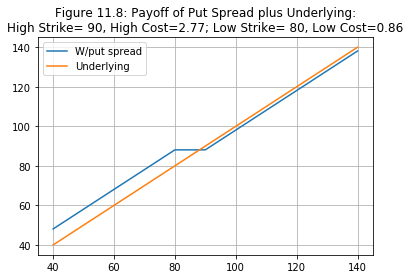

In [12]:
#Show payoff pattern of a put spread

x=np.arange(40,145,5)

#Value low-struck put
low_put_strike=80
low_put_cost=.86
low_put_price=[max(low_put_strike-xx,0) for xx in x]

high_put_strike=90
high_put_cost=2.77
high_put_price=[max(high_put_strike-xx,0) for xx in x]

put_spread_plus_under=x+high_put_price-low_put_price-high_put_cost+low_put_cost
plt.plot(x,put_spread_plus_under,label="W/put spread")
plt.plot(x,x,label="Underlying")
plt.grid()
plt.legend()
title_str="Figure 11.8: Payoff of Put Spread plus Underlying:\nHigh Strike=%3.f" % high_put_strike
title_str+=", High Cost=%2.2f" % high_put_cost
title_str+="; Low Strike=%3.f" % low_put_strike
title_str+=", Low Cost=%2.2f" %low_put_cost
plt.title(title_str)
plt.show()

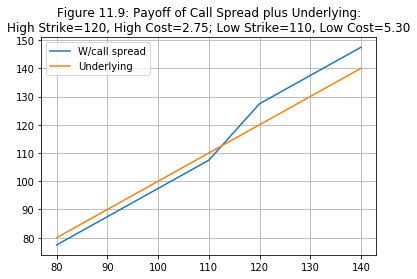

In [13]:
#Show payoff pattern of a call bull spread

x=np.arange(80,145,5)

#Value low-struck put
low_call_strike=110
low_call_cost=5.3
low_call_price=[max(xx-low_call_strike,0) for xx in x]

high_call_strike=120
high_call_cost=2.75
high_call_price=[max(xx-high_call_strike,0) for xx in x]

call_spread_plus_under=x+low_call_price-high_call_price-low_call_cost+high_call_cost
plt.plot(x,call_spread_plus_under,label="W/call spread")
plt.plot(x,x,label="Underlying")
plt.grid()
plt.legend()
title_str="Figure 11.9: Payoff of Call Spread plus Underlying:\nHigh Strike=%3.f" % high_call_strike
title_str+=", High Cost=%2.2f" % high_call_cost
title_str+="; Low Strike=%3.f" % low_call_strike
title_str+=", Low Cost=%2.2f" %low_call_cost
plt.title(title_str)
plt.show()

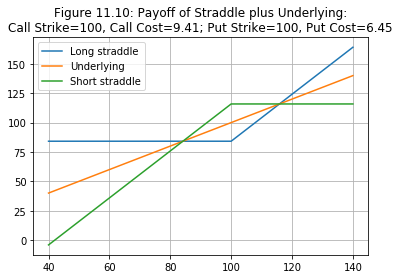

In [14]:
#Show payoff pattern of a straddle

x=np.arange(40,145,5)

common_strike=100
call_strike=common_strike
put_strike=common_strike
call_cost=9.41
put_cost=6.45

under_plus_straddle=[xx+max(xx-call_strike,0)+max(put_strike-xx,0)-call_cost-put_cost for xx in x]
under_minus_straddle=[xx-max(xx-call_strike,0)-max(put_strike-xx,0)+call_cost+put_cost for xx in x]

plt.plot(x,under_plus_straddle,label="Long straddle")
plt.plot(x,x,label="Underlying")
plt.plot(x,under_minus_straddle,label="Short straddle")
plt.grid()
plt.legend()
title_str="Figure 11.10: Payoff of Straddle plus Underlying:\nCall Strike=%3.f" % call_strike
title_str+=", Call Cost=%2.2f" % call_cost
title_str+="; Put Strike=%3.f" % put_strike
title_str+=", Put Cost=%2.2f" % put_cost
plt.title(title_str)
plt.show()

NameError: name 'low_strike' is not defined

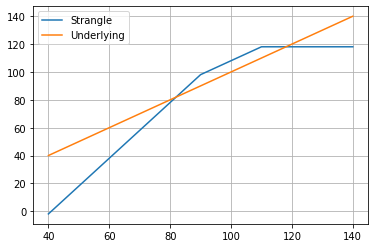

In [15]:
#Show payoff pattern of a strangle

x=np.arange(40,145,5)

low_put_strike=90
low_put_cost=2.77
high_call_strike=110
high_call_cost=5.30

strangle_plus_under=[xx-max(low_put_strike-xx,0)-max(xx-high_call_strike,0)+low_put_cost+high_call_cost for xx in x]

plt.plot(x,strangle_plus_under,label="Strangle")
plt.plot(x,x,label="Underlying")
plt.grid()
plt.legend()
title_str="Figure 11.11: Payoff of Strangle plus Underlying:\nLow Put Strike=%3.f" % low_strike
title_str+=", Low Put Cost=%2.2f" % low_cost
title_str+="; High Call Strike=%3.f" % high_strike
title_str+=", High Call Cost=%2.2f" % high_cost
plt.title(title_str)
plt.show()

In [ ]:
#Show payoff pattern of a butterfly spread

x=np.arange(70,125,5)
low_strike=90
mid_strike=100
high_strike=110
low_cost=15.43
mid_cost=9.41
high_cost=5.3

#payoff patterns for calls
low_payoff=[max(xx-low_strike,0) for xx in x]
mid_payoff=[max(xx-mid_strike,0) for xx in x]
high_payoff=[max(xx-high_strike,0) for xx in x]

butterfly_plus_under=x+low_payoff-mid_payoff-mid_payoff+high_payoff-low_cost+2*mid_cost-high_cost
plt.plot(x,butterfly_plus_under,label="W/butterfly")
plt.plot(x,x,label="Underlying")
plt.grid()
plt.legend()
title_str="Figure 11.12: Payoff of Butterfly plus Underlying:\n"
title_str+="Strikes=%3.f, %3.f, %3.f" % (low_strike, mid_strike, high_strike)
title_str+="; Costs=%3.2f, %3.2f, %3.2f" % (low_cost, mid_cost, high_cost)
plt.title(title_str)
plt.show()

In [ ]:
#Show payoff pattern of a zero cost collar

x=np.arange(40,145,5)
low_put_strike=90
high_call_strike=119

#payoff patterns
low_payoff=[max(low_put_strike-xx,0) for xx in x]
high_payoff=[max(xx-high_call_strike,0) for xx in x]

zcc_plus_under=x+low_payoff-high_payoff
plt.plot(x,zcc_plus_under,label="w/zc collar")
plt.plot(x,x,label="Underlying")
plt.grid()
plt.legend()
title_str="Figure 11.13: Payoff of Zero Cost Collar plus Underlying:\n"
title_str+="Strikes=%3.f, %3.f" % (low_put_strike, high_call_strike)
plt.title(title_str)
plt.show()

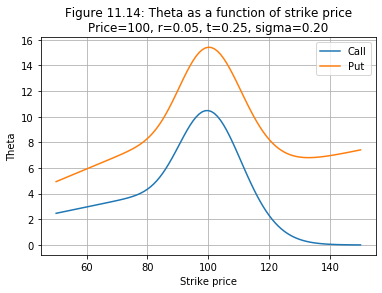

Price of ATM Call: 4.614997129602855
ATM Call Delta: 0.5694601832076737
Price of ATM Put: 3.372777178991001
Price of Call @ 100.1: 4.672139406393697
Empirical Delta: 0.5714227679084161


In [16]:
#Graph theta as a function of strike

def greeks(price,strike,r,time,sigma):
    #return a vector of Black-Scholes Greeks
    if price<=0 or strike<=0 or time<=0:
        return(6*[0])
    #Black-Scholes price
    d1=(np.log(price/strike)+(r+sigma**2/2)*time)/(sigma*np.sqrt(time))
    d2=d1-sigma*np.sqrt(time)
    n_of_d1=spst.norm.cdf(d1)
    n_of_d2=spst.norm.cdf(d2)
    bs_call=price*n_of_d1-np.exp(-r*time)*strike*n_of_d2
    #Greeks
    delta=n_of_d1
    gamma=np.exp(-d1**2/2)/(price*sigma*np.sqrt(2*np.pi*time))
    vega=time*gamma*sigma*(price**2)
    rho=strike*n_of_d2*time*np.exp(-r*time)
    #Use convention of reporting minus derivative for theta
    theta=.5*((price*sigma)**2)*gamma+r*rho/time
    gr_vec=[bs_call,delta,gamma,theta,vega,rho]
    return(gr_vec)

sigma=.2
r=.05
time=.25
price=100
strike=np.arange(50,151,1)

plt.plot(strike,[greeks(price,s,r,time,sigma)[3] \
                 for s in strike],label="Call")
#Use minus-derivative convention for theta
plt.plot(strike,[greeks(price,s,r,time,sigma)[3]+r*s*np.exp(-r*time) \
                 for s in strike],label="Put")
plt.xlabel("Strike price")
plt.ylabel("Theta")
plt.legend()
plt.grid()
str_title="Figure 11.14: Theta as a function of strike price\n"
str_title+="Price=%3.f" % price
str_title+=", r=%3.2f" % r
str_title+=", t=%3.2f" % time
str_title+=", sigma=%3.2f" % sigma
plt.title(str_title)
plt.show();

atm_call=greeks(price,price,r,time,sigma)[0]
print("Price of ATM Call:",atm_call)
dlta=greeks(price,price,r,time,sigma)[1]
print("ATM Call Delta:",dlta)
print("Price of ATM Put:",np.exp(-r*time)*price+ \
      greeks(price,price,r,time,sigma)[0]-price)
up_call=greeks(price+.1,price,r,time,sigma)[0]
print("Price of Call @ 100.1:",up_call)
emp_delta=(up_call-atm_call)/.1
print("Empirical Delta:",emp_delta)

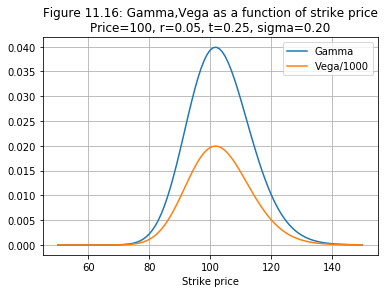

In [17]:
#Gamma and vega

plt.plot(strike,[greeks(price,s,r,time,sigma)[2] \
                 for s in strike],label="Gamma")
plt.plot(strike,[greeks(price,s,r,time,sigma)[4]/1000. \
                 for s in strike],label="Vega/1000")
plt.xlabel("Strike price")
plt.legend()
plt.grid()
str_title="Figure 11.16: Gamma,Vega as a function of strike price\n"
str_title+="Price=%3.f" % price
str_title+=", r=%3.2f" % r
str_title+=", t=%3.2f" % time
str_title+=", sigma=%3.2f" % sigma
plt.title(str_title)
plt.show();

In [ ]:
greeks(price,price,r,time,sigma)